<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [3]:
"""class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y"""

'class Data(Dataset):\n    def __init__(self, dataset):\n        super(Data, self).__init__()\n\n        self.dataset = dataset\n\n    def __len__(self):\n        return len(self.dataset)\n\n    def __getitem__(self, idx):\n        x = self.dataset.data[idx]\n        y = self.dataset.targets[idx]\n        return x, y'

In [4]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow,forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)
        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [5]:
def rescale(x, lo, hi):
    """Rescale a tensor to [lo,hi]."""
    assert(lo < hi), "[rescale] lo={0} must be smaller than hi={1}".format(lo,hi)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(hi-lo)
    new_center = lo + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [6]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

X_train = train_image.data.type(dtype=torch.float32)
y_train = train_image.targets

X_test = test_image.data.type(dtype=torch.float32)
y_test = test_image.targets

# Dequantization
uniform = torch.distributions.uniform.Uniform(torch.tensor([-0.5]), torch.tensor([0.5]))

X_train = torch.tensor(X_train) + uniform.sample(X_train.shape).squeeze()
X_train = rescale(X_train, 0., 1.).numpy()

X_test = torch.tensor(X_test)+ uniform.sample(X_test.shape).squeeze()
X_test = rescale(X_test, 0., 1.).numpy()

100%|██████████| 9912422/9912422 [00:00<00:00, 56076015.58it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27480874.28it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25114722.62it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19223540.63it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



<ipython-input-6-2bf555d63314>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train) + uniform.sample(X_train.shape).squeeze()
<ipython-input-6-2bf555d63314>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)+ uniform.sample(X_test.shape).squeeze()


In [7]:
train_data = Data(X_train)
test_data = Data(X_test)

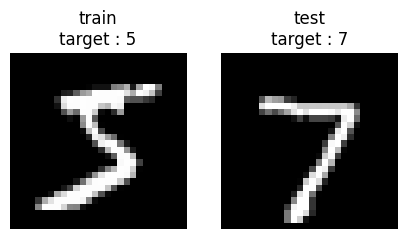

In [8]:
image_train = train_data[0]
category_train = y_train[0]
image_test = test_data[0]
category_test = y_test[0]

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [9]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)


In [10]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%10 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1028.2891256129487
Epoch :  10   -----------> Loss :  -450.0190697203291
Epoch :  20   -----------> Loss :  -1261.6472126412898
Epoch :  30   -----------> Loss :  -1560.712071974734
Epoch :  40   -----------> Loss :  -1648.4893081989694
Epoch :  50   -----------> Loss :  -1687.0791031208444
Epoch :  60   -----------> Loss :  -1715.7224131482712
Epoch :  70   -----------> Loss :  -1733.9799331989693
Epoch :  90   -----------> Loss :  -1780.8982780294216
Epoch :  100   -----------> Loss :  -1780.0466204704123


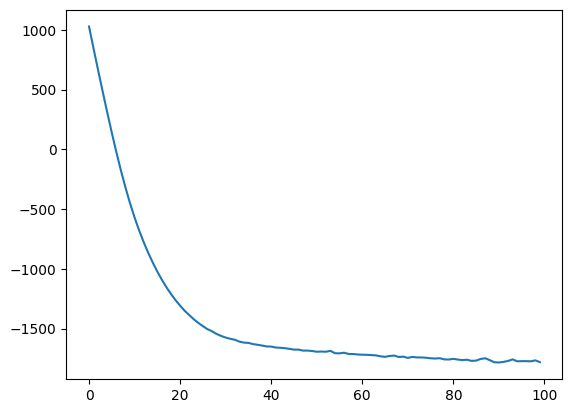

In [11]:
plt.plot(COST)

In [12]:
test = prior.sample((50,))
test

tensor([[-0.6038,  0.6369, -0.0137,  ..., -0.9691, -1.0685,  1.5483],
        [-0.9935, -1.8323,  2.3178,  ..., -0.0647,  0.4895, -0.8203],
        [-0.7637,  0.9021,  1.9738,  ...,  1.4535, -1.4897, -0.0248],
        ...,
        [ 0.9818, -0.0219, -0.3818,  ...,  1.4528,  1.5046,  1.4009],
        [-0.4406, -1.2939, -0.7461,  ...,  0.4066, -1.5927,  0.1558],
        [ 0.5791,  0.4169,  1.9145,  ...,  0.3421, -0.0406, -0.6481]])

In [13]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 1.8105e-03,  2.9190e-04,  6.8446e-04,  ...,  1.9037e-03,
          1.3094e-03,  3.6295e-03],
        [ 1.4556e-03,  1.8477e-03,  1.3777e-03,  ...,  3.3735e-03,
          7.9237e-04,  1.5559e-03],
        [ 2.3561e-03, -5.7483e-04,  2.0917e-03,  ...,  2.8726e-03,
          1.4164e-05,  2.4659e-03],
        ...,
        [ 2.6974e-03,  1.1825e-03,  1.2477e-03,  ...,  1.0241e-03,
          1.6223e-03,  2.6675e-03],
        [ 5.7667e-05,  1.8501e-03,  1.9010e-03,  ...,  2.4612e-03,
          1.7632e-03,  1.0897e-03],
        [ 2.1368e-03,  1.1149e-03,  2.8517e-03,  ..., -1.2375e-04,
          3.9514e-04,  1.3629e-04]], grad_fn=<MulBackward0>)

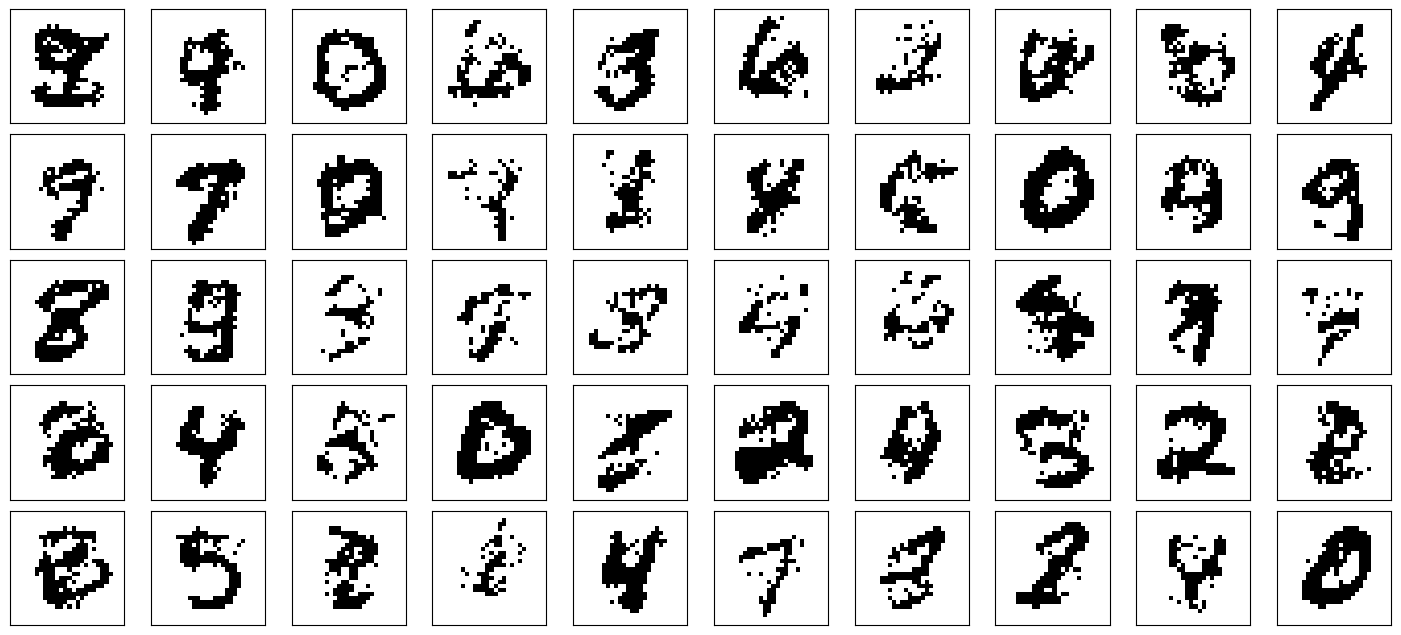

In [14]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.3] = 1
sonuc[sonuc[:]<=0.3] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

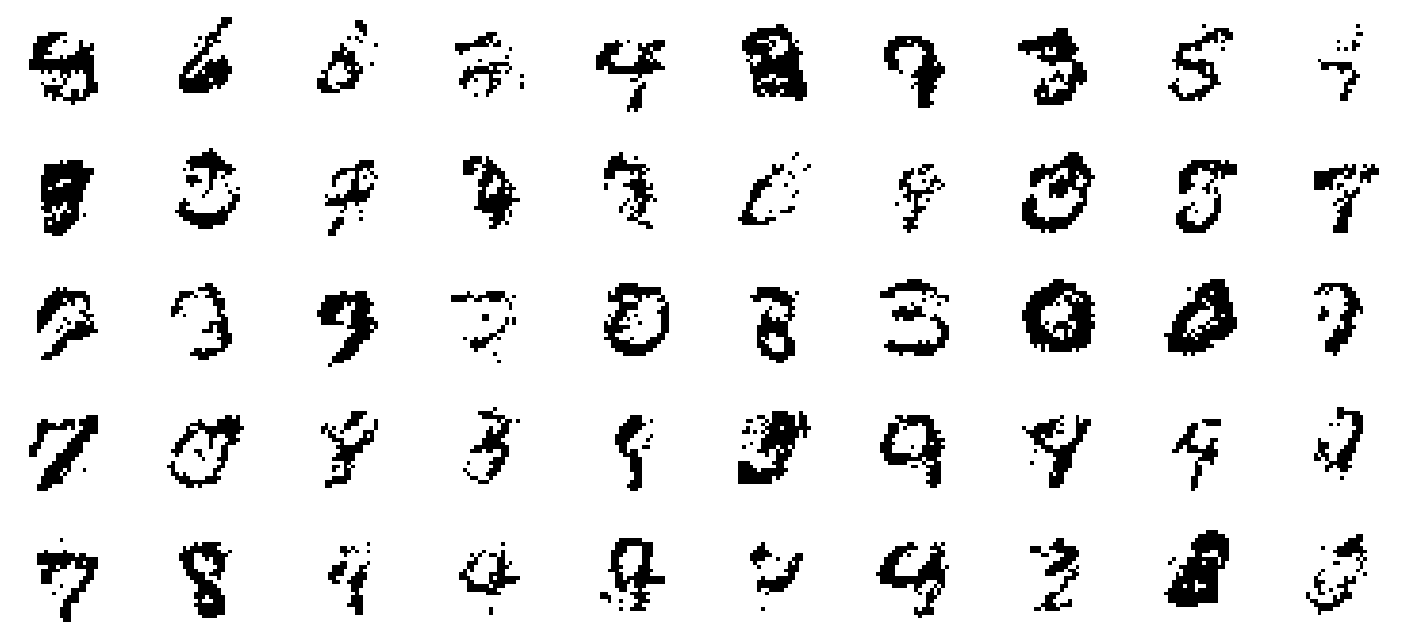

In [15]:
test = prior.sample((50,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.4] = 1
sonuc[sonuc[:]<=0.4] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
    axs[3, i].axis('off')
    axs[4, i].axis('off')
fig.show()

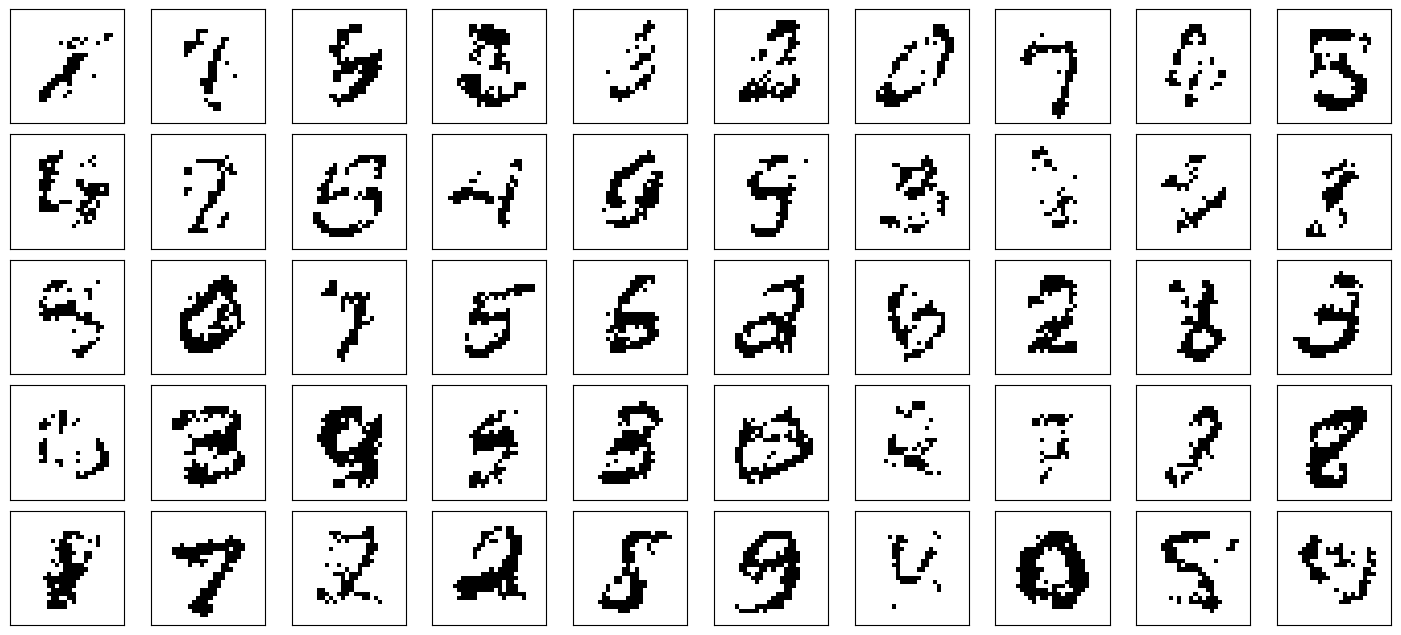

In [16]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)

sonuc[sonuc[:]>0.5] = 1
sonuc[sonuc[:]<=0.5] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

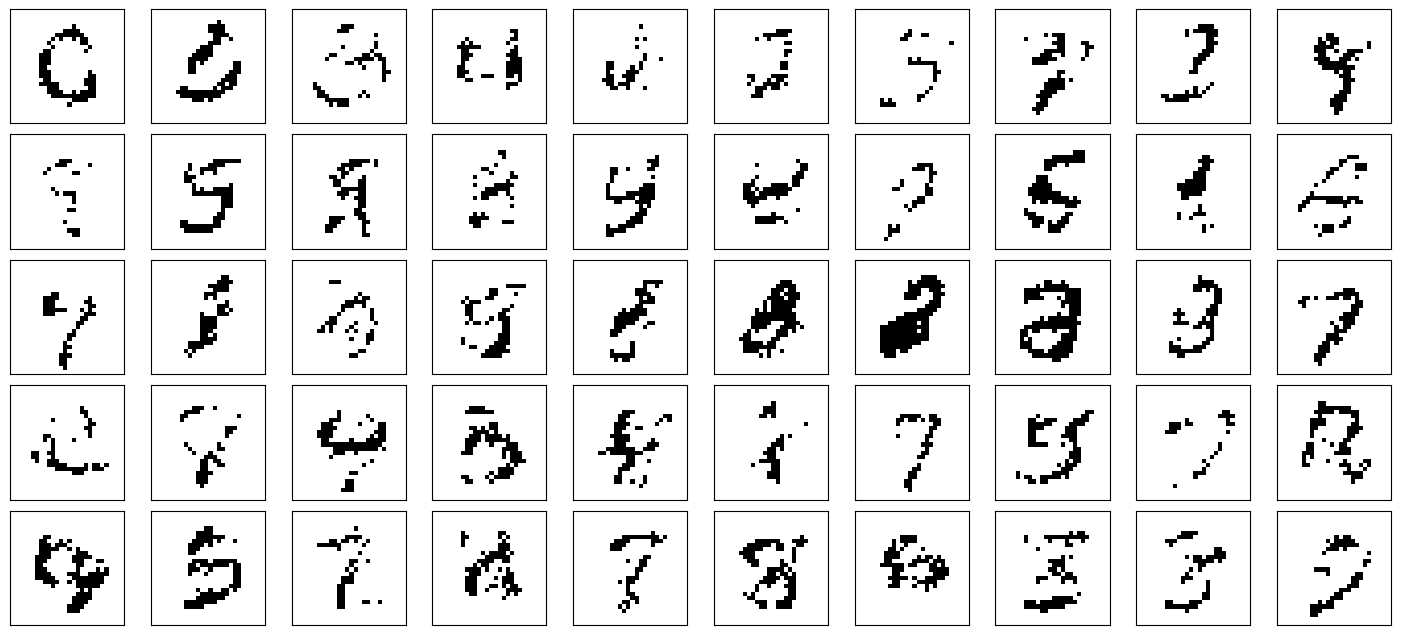

In [17]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.6] = 1
sonuc[sonuc[:]<=0.6] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

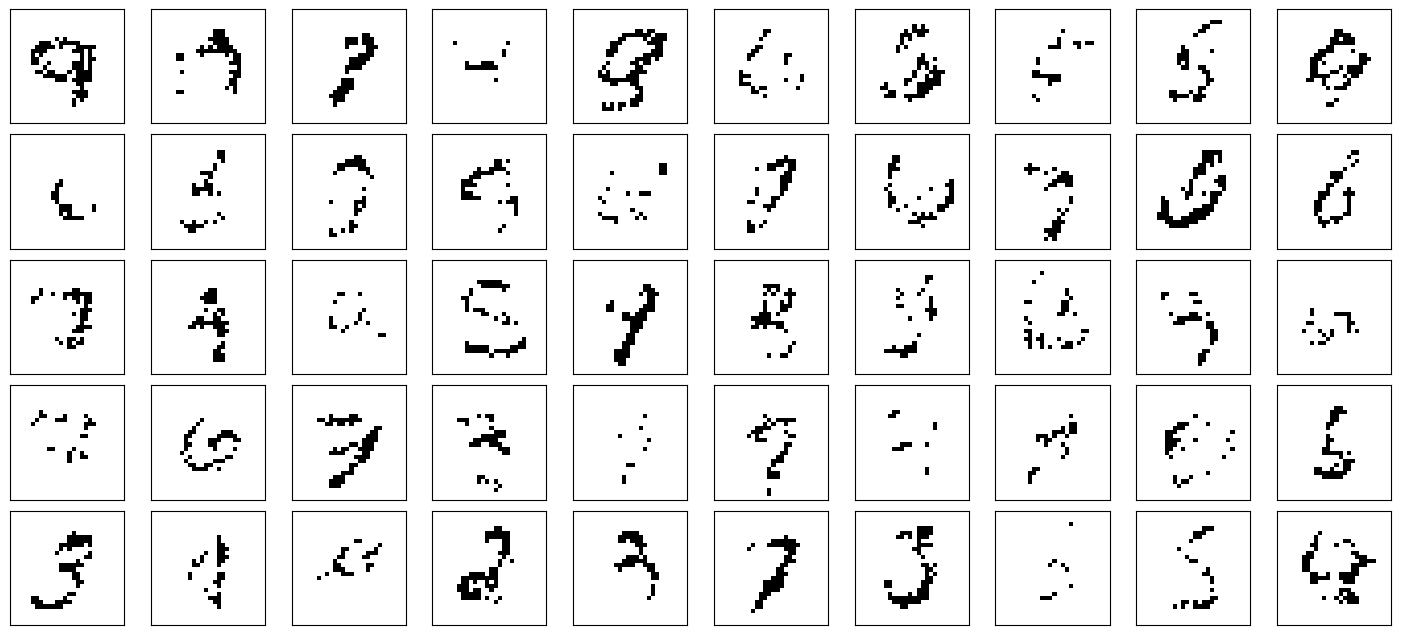

In [18]:
test = prior.sample((1797,))
sonuc = (model.f_inv(test))
sonuc[sonuc[:]>0.7] = 1
sonuc[sonuc[:]<=0.7] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

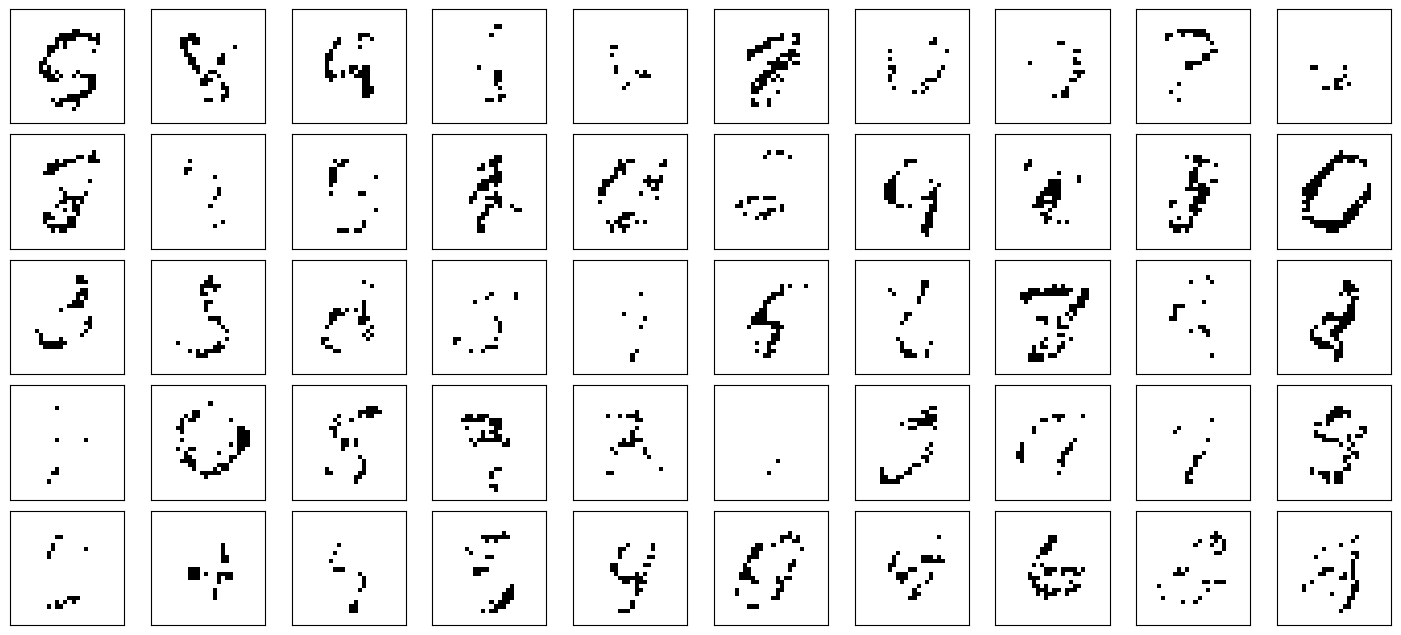

In [19]:
test = prior.sample((1797,))
sonuc = (model.f_inv(test))
sonuc[sonuc[:]>0.8] = 1
sonuc[sonuc[:]<=0.8] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()